In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
img = cv2.imread('F:\\University\\Fall 2022\\image\\Face-Detection-and-Pyramid-Blending\\facedetection\\data\\images\\friends.jpeg')

(1600, 1200, 3) (3200, 2400, 3)


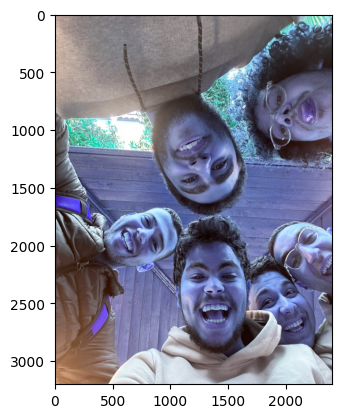

In [6]:
img_resized = cv2.resize(img,(0,0),fx=2,fy=2,interpolation=cv2.INTER_LINEAR)
print(img.shape,img_resized.shape)
plt.imshow(img_resized)

In [6]:
def number_of_octaves(image):
   return int(round(np.log(min(image.shape)) / np.log(2) - 1))


def generate_base_image(image,sigma,assumed_blur):
    #we will upsample the image
    image = cv2.resize(image,(0,0),fx=2,fy=2,interpolation=cv2.INTER_LINEAR)
    #we added the 0.01 to prevent zeros
    differnece_of_sigmas = math.sqrt(max((sigma**2) - (2*assumed_blur)**2,0.01 ))
    
    return cv2.GaussianBlur(image,(0,0),sigmaX=differnece_of_sigmas,sigmaY=differnece_of_sigmas)

#Step 1: generate scale space for image
# def generate_scale_space(image,number_of_octaves,number_of_blurring):
#     #for each octave level, we will generate for the same image size gaussian blurred number_of_blurring times
    
    
def generate_sigma_kernels(sigma,num_of_interval):
    number_of_images_per_octave = num_of_interval + 3 #as shown in paper
    k = 2**(1./number_of_images_per_octave) #as shown in paper
    gaussian_kernels = np.zeros(number_of_images_per_octave)
    gaussian_kernels[0] = sigma
    for index in range(1,number_of_images_per_octave):
        gaussian_kernels[index] = k * gaussian_kernels[index-1] #as shown in lecture slides
    return gaussian_kernels

def generate_gaussian_images(image,number_of_octaves,gaussian_kernels):
    gaussian_images = []
    for octave_index in range(number_of_octaves):
        gaussian_images_in_octave = []
        
        #TODO if failed do as the paper
        for kernel in gaussian_kernels[0:]:
            image = cv2.GaussianBlur(image,(0,0),sigmaX=kernel,sigmaY=kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        
        #TODO: check why we choose the middle image as our base
        octave_base = gaussian_images_in_octave[-3] 
        #down sample the image to be half the size
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    return np.array(gaussian_images,dtype=object)
            

def generate_difference_of_gaussian_images(gaussian_images):
    
    number_of_octaves = len(gaussian_images)
    number_of_images_per_octave = len(gaussian_images[0])
    DOG_images = []
    for each_octave in gaussian_images:
        current_DOG_images= []
        for index in range(0,number_of_images_per_octave-1):
            current_DOG_images.append(cv2.subtract(each_octave[index+1],each_octave[index]))
        DOG_images.append(current_DOG_images)
    return DOG_images
            

            
    

In [11]:
def is_pixel_extrma(first_window,second_window,third_window,threshold):
    """
    If i am bigger than all 26 pixel or iam smaller than smaller
    printz

    """
    # print("first window size",first_window,first_window.shape)
    center_pixel = second_window[1,1] #pick the middle pixel
    # print("center pixel is",center_pixel)
    if(abs(center_pixel) > threshold): #to avoid edges
        if center_pixel > 0:
            
           return np.all(center_pixel >=first_window) and \
                    np.all(center_pixel >= third_window) and \
                    np.all(center_pixel >= second_window[0, :]) and \
                    np.all(center_pixel >= second_window[2, :]) and \
                    (center_pixel >= second_window[1, 0]) and \
                    (center_pixel >= second_window[1, 2])
        elif center_pixel < 0:
            return np.all(center_pixel <= first_window)and \
                   np.all(center_pixel <= third_window)and \
                   np.all(center_pixel <= second_window[0, :])and \
                   np.all(center_pixel <= second_window[2, :])and \
                   center_pixel <= second_window[1, 0] and \
                   center_pixel <= second_window[1, 2]
    return False
    
    

In [20]:
def get_key_points(image,DOG_images,gaussian_images,image_border_width,contrast_threshold=0.03,number_of_intervals=2):
    threshold = math.floor(0.5 * contrast_threshold / number_of_intervals * 255)
    keypoints = []
    for octave_index,dog_image_in_octave in enumerate(DOG_images):
        #loop through each octave and corresponding DOG images
        for image_index, (first_image,second_image,third_image) in enumerate(zip(dog_image_in_octave,dog_image_in_octave[1:],dog_image_in_octave[2:])):
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if is_pixel_extrma(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        # we have current_octave, image_index_in that octave,#i,j key point of that image
                        keypoints.append((i,j,octave_index,image_index))
                        
    return keypoints

In [21]:
def pipeline(img):
    number_of_octaves=4
    number_of_gaussian_kernels=5 #as in slides
    gaussian_kernels = generate_sigma_kernels(1.1,number_of_gaussian_kernels)
    gaussian_images = generate_gaussian_images(img,number_of_octaves,gaussian_kernels)
    dog_images = generate_difference_of_gaussian_images(gaussian_images)
    key_points = get_key_points(img,dog_images,gaussian_images,5,0.03)
    return key_points,gaussian_images

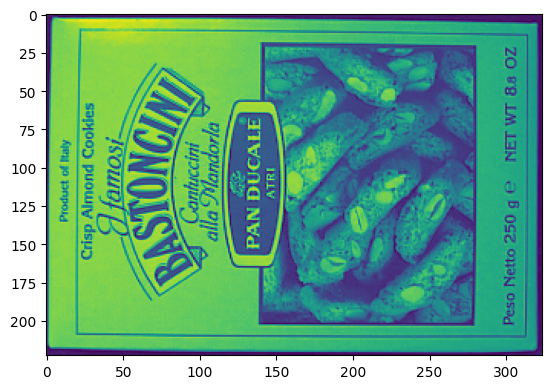

In [18]:
img = cv2.cvtColor(cv2.cvtColor(cv2.imread("box.png"),cv2.COLOR_BGR2RGB),cv2.COLOR_RGB2GRAY)

plt.imshow(img)


In [22]:
key_points,octave_images = pipeline(img)

In [24]:
for key_point in key_points:
    i,j,octave,img_index = key_point
    img[i,j] = 0

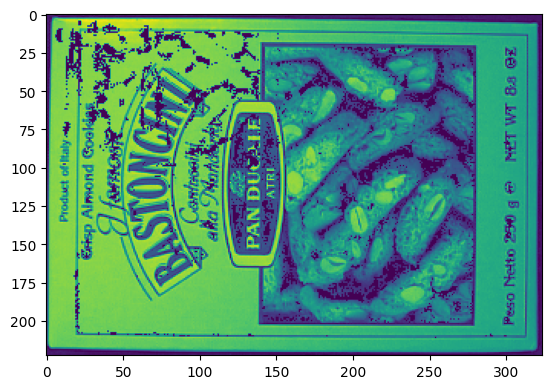

In [25]:
plt.imshow(img)

In [ ]:
def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])